# Natural Computing

This is an exercise from 2019/2 period of the course "Natural Computing" at UFES, in Vitória/ES - Brazil.

Task: Compare different nature-inspired optimization algorithms.

Master's degree candidate: Bruno Carvalho

## Algorithms

- GA - Genetic Algorithms
- GP - Genetic Programming
- ES - Evolution Strategy
- DE - Differential Evolution

- PSO - Particle Swarm Optimization [Kennedy and Eberhart, 1995]
- ACO - Ant Colony Optimization [Korošec and Šilc, 2009]
- CS - Cuckoo Search
- GWO - Grey Wolf Optimizer
- MVO - Multi-Verse Optimizer
- MFO - Moth-flame Optimization 
- WOA - Whale Optimization Algorithm
- BAT - Bat Algorithm
- FFA - Firefly Algorithm

## References

.

In [1]:
import os
import sys
import time
import itertools
import random

import numpy as np
import pandas as pd

from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'


In [2]:
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

In [3]:
execution_dict = {
    'time_elapsed': 0,
    'algorithm': '',
    'metrics': {
        'best': [],
        'time': [],
        'objective': [],
        'scores': [],
    }
}

In [4]:
def ga_optimizer(obj_func, parameters):
    """

    Inspired by:
    https://github.com/7ossam81/EvoloPy/blob/master/GA.py

    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    population = parameters.get('population', 100)
    crossover_rate = parameters.get('crossover_rate', 1.0)
    mutation_rate = parameters.get('mutation_rate', 0.01)
    best_to_keep = parameters.get('best_to_keep', 2)
    crossover_alpha = parameters.get('crossover_alpha', 0.25)
    
    np.random.seed(seed)
    
    # Input Objective function has variable dimensions
    # consider equi-distance "square"
    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    
    # allocate memory
    exec_info['metrics']['time'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['best'] = np.zeros([max_iterations, dimension], dtype='float')
    exec_info['metrics']['objective'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['scores'] = np.full([max_iterations, population], np.inf, dtype='float')

    begin = time.time()

    # search space - Zero init array
    #space = np.full([population, dimension], 0.0)
    space = np.random.uniform(0, 1, [population, dimension])

    # objective evaluation scores
    scores = np.random.uniform(0.0, 1.0, population)
    
    def crossover(space, scores):
        search_space = np.zeros_like(space) + np.random.uniform(0, 1)
        #search_space = np.zeros_like(space)
        search_space[0:best_to_keep, :] = space[0:best_to_keep, :]
        
        # renew BETA every generation
        beta = np.random.uniform(-crossover_alpha, 1 + crossover_alpha)
        
        for cross  in range(best_to_keep + 1, population - 1, 2):

            # using SET parents will always be different
            #parents = set()
            
            # using LIST parents can repeat!
            parents = []
            
            parent1_idx = np.random.randint(0, population)
            parent2_idx = np.random.randint(0, population)
            
            parents.append(parent1_idx)
            parents.append(parent2_idx)

            """
            while len(parents) < 2:
                parent1_idx = np.random.randint(0, population)
                parent2_idx = np.random.randint(0, population)
            
                if scores[parent1_idx] > scores[parent2_idx]:
                    # p1 is better then p2
                    parents.add(parent1_idx)
                else:
                    parents.add(parent2_idx)               
            """
            
            lp = list(parents)
            parent1 = space[lp[0], :]
            parent2 = space[lp[1], :]
            
            # ARITHMETIC CROSSOVER
            child1 = parent1 * beta + (1.0 - beta) * parent2
            child2 = parent2 * beta + (1.0 - beta) * parent1
            
            crossover_chance = np.random.uniform(0.0, 1.0)
            if crossover_chance < crossover_rate:
                search_space[cross, :] = np.copy(child1)
                search_space[cross + 1, :] = np.copy(child2)  
            else:
                search_space[cross, :] = np.copy(parent1)
                search_space[cross + 1, :] = np.copy(parent2)
            
            for j in range(dimension):
                search_space[cross, j] = np.clip(search_space[cross, j], lower[j], upper[j])
                search_space[cross + 1, j] = np.clip(search_space[cross + 1, j], lower[j], upper[j])
                
        return search_space
    
    def mutation(space, gen):
        n_mutate = np.int(population * mutation_rate)
        for m in range(n_mutate):
            # keep best => do not mutate
            rand_individual = np.random.randint(best_to_keep + 1, population)
            #rand_individual = np.random.randint(0, population)
            # decrease stdev with generations
            #stdev = 5.0 / np.sqrt(gen)
            stdev = 2
            new_value = np.zeros(dimension)
            for j in range(dimension):
                new_value[j] = np.random.normal(space[rand_individual, j], stdev)
                new_value[j] = np.clip(new_value[j], lower[j], upper[j])

            # store
            space[rand_individual, :] = new_value

        return space
    
    def sort_iter(_space, _scores):
        idx = scores.argsort()
        _space = _space[idx]
        _scores = _scores[idx]
        return _space, _scores
    
    def eval_obj(func, _space):
        _scores = np.full(population, np.inf)
        for p in range(population):
            _scores[p] = func(_space[p, :])
        return _scores

    for i in range(dimension):
        space[:, i] = np.random.uniform(0, 1, population) * (upper[i] - lower[i]) + lower[i]
    
    for _iter in range(1, max_iterations):
        
        # crossover
        space = crossover(space, scores)
        
        # mutation
        space = mutation(space, _iter)
        
        # evaluate objective
        scores = eval_obj(obj_func, space)
        
        # remove duplicates
        
        # sort
        space, scores = sort_iter(space, scores)
        
        # save
        exec_info['metrics']['scores'][_iter] = scores
        exec_info['metrics']['time'][_iter] = time.time() - begin
        exec_info['metrics']['best'][_iter] = space[0, :]
        
        if _iter % np.int(max_iterations / 10) == 0:
            print(f'\tGen {_iter:06d} (10%), '
                  f'f_min = {scores[0]:+13.5e}, '
            )
            #print(
            #      f'\tx[0, 0] = {space[0, 0]:+13.5e}, '
            #      f'x[0, d] = {space[0, -1]:+13.5e}, '
            #      f'x[p, d] = {space[-1, -1]:+13.5e}'
            #)
            #print(space)
            #print(scores)

    exec_info['algorithm'] = 'GA - Genetic Algorithm'
    exec_info['time_elapsed'] = time.time() - begin
    #print(space)
    #print(scores)
    #print(scores.shape)
    
    return exec_info

In [5]:
def pso_optimizer(obj_func, parameters):
    """

    Inspired by:
    https://github.com/7ossam81/EvoloPy/blob/master/PSO.py

    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    velocity_max = np.full(dimension, parameters.get('velocity_max', 5.0))
    
    w_max = parameters.get('w_max', 0.9)
    w_min = parameters.get('w_min', 0.2)

    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    exec_info['metrics']['scores'] = np.zeros(max_iterations, dtype='float')

    # inner variables
    
    c1 = 2.0
    c2 = 2.0
    
    velocity = np.full([population, dimension], 0.0)
    
    p_best_score = np.full(population, np.inf)
    p_best = np.full([population, dimension], 0.0)
    
    g_best_score = np.inf
    g_best = np.full(population, 0.0)
    
    space = np.full([population, dimension], 0.0)
    
    begin = time.time()

    # init fill
    for _d in range(dimension):
        rand_dim = np.random.uniform(0, 1, population)
        space[:, _d] = rand_dim * (upper[_d] - lower[_d]) + lower[_d]
    
    for _iter in range(max_iterations):
        for _p in range(population):
            # keep inside bounds / search limits
            space[_p, :] = np.clip(space[_p, :], lower, upper)
            
            # eval
            score = obj_func(space[_p, :])
            
            # check
            if p_best_score[_p] > score:
                p_best_score[_p] = score
                p_best[_p, :] = np.copy(space[_p, :])
            
            if g_best_score > score:
                g_best_score = score
                g_best = np.copy(space[_p, :])
        
        w = w_max - _iter * ((w_max - w_min) / max_iterations)
        
        for _p in range(population):
            r1 = np.random.random([dimension])
            r2 = np.random.random([dimension])
            
            v = velocity[_p, :]
            
            a1 = c1 * r1 * (p_best[_p, :] - space[_p, :])
            a2 = c2 * r2 * (g_best - space[_p, :])
            
            #r = w * v + a1 + a2
            #print(r)
            
            velocity[_p, :] = w * v + a1 + a2
            
            velocity[_p, :] = np.fmax(velocity[_p, :], -velocity_max)  # negative!!
            velocity[_p, :] = np.fmin(velocity[_p, :],  velocity_max)
            
            # UPDATE space
            space[_p, :] += velocity[_p, :]

        # save data to analyse and plot later
        exec_info['metrics']['scores'][_iter] = g_best_score
        
        # some logging
        if _iter % np.int(max_iterations / 10.0) == 0:
            print(f'\tIteration {_iter:05d}, f_minx = {g_best_score:+12.5e}')

    # finished
    exec_info['algorithm'] = 'PSO - Particle Swarm Optimization'
    exec_info['time_elapsed'] = time.time() - begin

    return exec_info

In [ ]:
def bb_pso_optimizer():
    """


    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    velocity_max = np.full(dimension, parameters.get('velocity_max', 5.0))

    np.random.seed(seed)

    w_max = parameters.get('w_max', 0.9)
    w_min = parameters.get('w_min', 0.2)

    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    exec_info['metrics']['scores'] = np.zeros(max_iterations, dtype='float')

    # inner variables

    c1 = 2.0
    c2 = 2.0

    velocity = np.full([population, dimension], 0.0)

    p_best_score = np.full(population, np.inf)
    p_best = np.full([population, dimension], 0.0)

    g_best_score = np.inf
    g_best = np.full(population, 0.0)

    space = np.full([population, dimension], 0.0)

    begin = time.time()

    # init fill
    for _d in range(dimension):
        rand_dim = np.random.uniform(0, 1, population)
        space[:, _d] = rand_dim * (upper[_d] - lower[_d]) + lower[_d]

    for _iter in range(max_iterations):
        for _p in range(population):
            # keep inside bounds / search limits
            space[_p, :] = np.clip(space[_p, :], lower, upper)

            # eval
            score = obj_func(space[_p, :])

            # check
            if p_best_score[_p] > score:
                p_best_score[_p] = score
                p_best[_p, :] = np.copy(space[_p, :])

            if g_best_score > score:
                g_best_score = score
                g_best = np.copy(space[_p, :])

        w = w_max - _iter * ((w_max - w_min) / max_iterations)

        for _p in range(population):
            r1 = np.random.random([dimension])
            r2 = np.random.random([dimension])

            v = velocity[_p, :]

            a1 = c1 * r1 * (p_best[_p, :] - space[_p, :])
            a2 = c2 * r2 * (g_best - space[_p, :])

            velocity[_p, :] = w * v + a1 + a2

            velocity[_p, :] = np.fmax(velocity[_p, :], -velocity_max)  # negative!!
            velocity[_p, :] = np.fmin(velocity[_p, :],  velocity_max)

            # UPDATE space
            space[_p, :] += velocity[_p, :]

        # save data to analyse and plot later
        exec_info['metrics']['scores'][_iter] = g_best_score

        # some logging
        if _iter % np.int(max_iterations / 10.0) == 0:
            print(f'\tIteration {_iter:05d}, f_minx = {g_best_score:+12.5e}')

    # finished
    exec_info['algorithm'] = 'PSO - Particle Swarm Optimization'
    exec_info['time_elapsed'] = time.time() - begin

    return exec_info

In [ ]:
def es_optimizer()

In [6]:
def ackley_function(x):
    """David Ackley, 1987.
    
    Minimum is ZERO at x = [0, 0, ..., 0]
    
    """
    n = x.shape[0]
    exp1 = -0.2 * np.sqrt((1/n) * np.dot(x.T, x))
    exp2 = (1/n) * np.sum(np.cos(2 * np.pi * x))
    return np.squeeze(-20 * np.exp(exp1) - np.exp(exp2) + 20 + np.e)

In [7]:
def rastrigin_function(x):
    pass

In [8]:
def sphere_function(x):
    pass

In [9]:
def rosenbrock_function(x):
    pass

In [10]:
def beale_function(x):
    pass

In [11]:
def goldstein_price_function(x):
    pass

In [12]:
def booth_function(x):
    pass

In [13]:
def bukin_function_6(x):
    pass

In [14]:
def matyas_function(x):
    pass

In [15]:
def levi_function_13(x):
    pass

In [16]:
def himmelblau_function(x):
    pass

In [17]:
def three_hump_camel_function(x):
    pass

In [18]:
def easom_function(x):
    pass

In [19]:
def cross_in_tray_function(x):
    pass

In [20]:
def eggholder_function(x):
    pass

In [21]:
def hoelder_table_function(x):
    pass

In [22]:
def mccormick_function(x):
    pass

In [23]:
def schaffer_function_2(x):
    pass

In [24]:
def schaffer_function_4(x):
    pass

In [25]:
def styblinski_tang_function(x):
    pass

In [26]:
params = {
    'seed': 5
}
results = []

total_ndim = 10
for _dim in range(2, total_ndim + 1):
    params = {
        'seed': 1,
        'dimension': _dim,
        'max_iterations': 1000,
        'population': 100,
        'upper': [30],
        'lower': [-30],
    }
    print(f'Dimensions: {_dim}')
    ga_result = ga_optimizer(ackley_function, params)
    results.append(ga_result.copy())
    print(f"\tTop 5 f(x) values, after {ga_result['time_elapsed']:7.2f}s")
    print('\tf=', ga_result['metrics']['scores'][-1][:5])
    print('\tx=')
    for xv in ga_result['metrics']['best'][-1]:
        print(f'\t\t {xv:+12.7e}')


Dimensions: 2
	Gen 000100 (10%), f_min =  +1.24516e-02, 
	Gen 000200 (10%), f_min =  +7.35933e-03, 
	Gen 000300 (10%), f_min =  +4.47820e-03, 
	Gen 000400 (10%), f_min =  +3.03154e-03, 
	Gen 000500 (10%), f_min =  +3.03154e-03, 
	Gen 000600 (10%), f_min =  +2.64912e-03, 
	Gen 000700 (10%), f_min =  +2.57036e-03, 
	Gen 000800 (10%), f_min =  +2.57036e-03, 
	Gen 000900 (10%), f_min =  +5.76225e-04, 
	Top 5 f(x) values, after    1.70s
	f= [0.00057623 0.00060124 0.02075629 0.04492558 0.04832589]
	x=
		 -1.7152391e-04
		 +1.0920422e-04
Dimensions: 3
	Gen 000100 (10%), f_min =  +5.52037e-03, 
	Gen 000200 (10%), f_min =  +4.92657e-03, 
	Gen 000300 (10%), f_min =  +2.01951e-03, 
	Gen 000400 (10%), f_min =  +2.01951e-03, 
	Gen 000500 (10%), f_min =  +2.01951e-03, 
	Gen 000600 (10%), f_min =  +2.01951e-03, 
	Gen 000700 (10%), f_min =  +2.01951e-03, 
	Gen 000800 (10%), f_min =  +2.01951e-03, 
	Gen 000900 (10%), f_min =  +2.01951e-03, 
	Top 5 f(x) values, after    1.73s
	f= [0.00201951 0.00201951 

In [27]:
dim = 2
r_dim = results[0]
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2][0])

Text(0, 0.5, 'log of f')

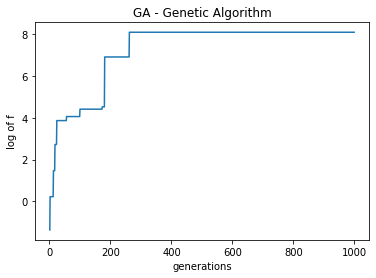

In [29]:
# change plot scale to LOG => better view
plt.plot(-np.log(y_plot))

plt.title('GA - Genetic Algorithm')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

In [30]:
params = {
    'seed': 5
}

results = []
total_ndim = 10

for _dim in range(2, total_ndim + 1):
    params = {
        'seed': 1,
        'dimension': _dim,
        'max_iterations': 1000,
        'population': 100,
        'upper': [30],
        'lower': [-30],
    }
    print(f'Dimensions: {_dim}')
    ga_result = pso_optimizer(ackley_function, params)
    results.append(ga_result.copy())
    print(f"\tTop 5 f(x) values, after {ga_result['time_elapsed']:7.2f}s")
    print('\tf=', ga_result['metrics']['scores'][-5:])


Dimensions: 2
Iteration 00000, f_minx = +6.94877e+00
Iteration 00100, f_minx = +1.09278e-02
Iteration 00200, f_minx = +3.75330e-04
Iteration 00300, f_minx = +4.53395e-07
Iteration 00400, f_minx = +3.24154e-11
Iteration 00500, f_minx = +3.99680e-15
Iteration 00600, f_minx = +4.44089e-16
Iteration 00700, f_minx = +4.44089e-16
Iteration 00800, f_minx = +4.44089e-16
Iteration 00900, f_minx = +4.44089e-16
	Top 5 f(x) values, after    2.34s
	f= [4.4408921e-16 4.4408921e-16 4.4408921e-16 4.4408921e-16 4.4408921e-16]
Dimensions: 3
Iteration 00000, f_minx = +1.37851e+01
Iteration 00100, f_minx = +3.71637e-01
Iteration 00200, f_minx = +1.30966e-02
Iteration 00300, f_minx = +5.57709e-06
Iteration 00400, f_minx = +6.61587e-09
Iteration 00500, f_minx = +2.63345e-13
Iteration 00600, f_minx = +4.44089e-16
Iteration 00700, f_minx = +4.44089e-16
Iteration 00800, f_minx = +4.44089e-16
Iteration 00900, f_minx = +4.44089e-16
	Top 5 f(x) values, after    2.35s
	f= [4.4408921e-16 4.4408921e-16 4.4408921e-16

In [31]:
dim = 2
r_dim = results[0]
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2])

Text(0, 0.5, 'log of f')

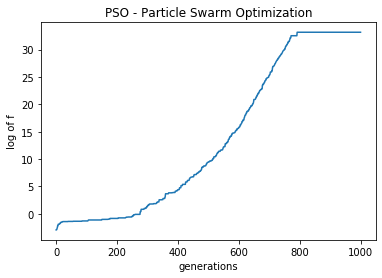

In [32]:
plt.plot(-np.log(y_plot))
plt.title('PSO - Particle Swarm Optimization')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')